In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import datetime

## Prepare the data

In [23]:
# Dataset Parameters
root = './dataset/'
batch_size = 16
img_height = 256
img_width = 256
seed = 42

In [24]:
# importing the training split
train_ds = keras.utils.image_dataset_from_directory(
  root + 'train/',
  validation_split=0,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4757 files belonging to 29 classes.
Using 3806 files for training.


In [25]:
# importing the validation split
val_ds = keras.utils.image_dataset_from_directory(
  root + 'test/',
  validation_split=1,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4757 files belonging to 29 classes.
Using 951 files for validation.


# Hyperparameter initialisation and Dataset finalization

In [26]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [27]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Chickenpox', 'Cowpox', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'HFMD', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Healthy', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Measles', 'Melanoma Skin Cancer Nevi and Moles', 'Monkeypox', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
29


In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [29]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


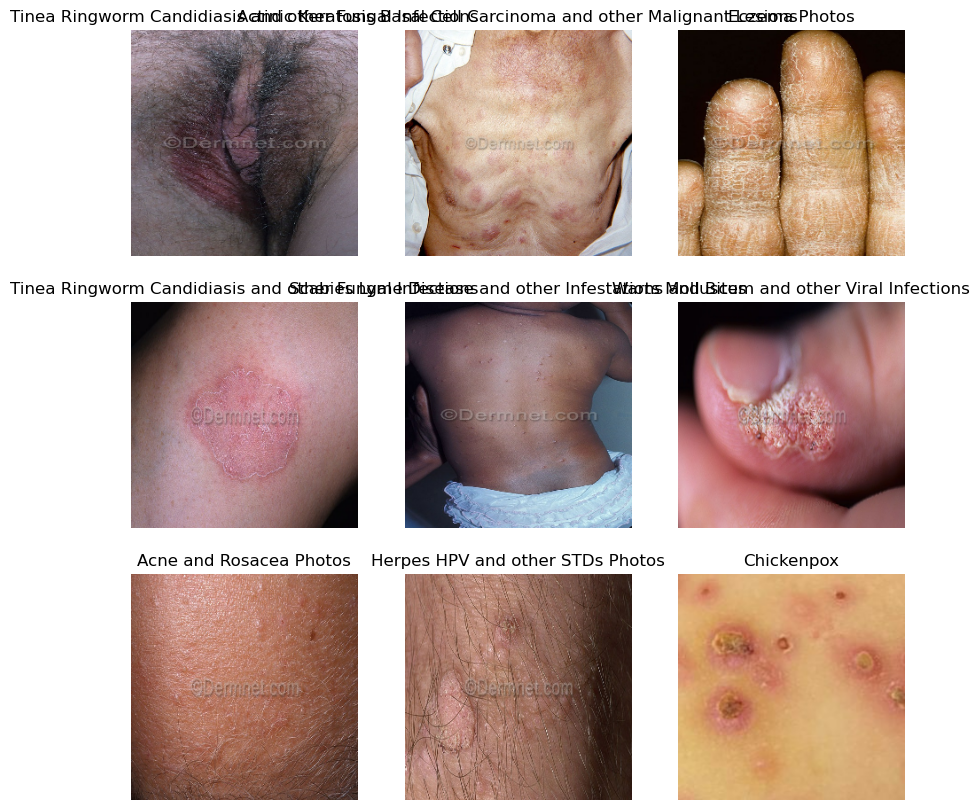

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [31]:
%reload_ext tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Conv2D(64, 3, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Conv2D(32, 3, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Dense(8 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Dense(2 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=125,
  callbacks=[tensorboard_callback]
)

Epoch 1/125


238/238 [==============================] - 13s 44ms/step - loss: 3.2147 - accuracy: 0.0746 - val_loss: 3.1313 - val_accuracy: 0.0852
Epoch 2/125
238/238 [==============================] - 11s 45ms/step - loss: 3.1036 - accuracy: 0.0956 - val_loss: 3.1187 - val_accuracy: 0.1052
Epoch 3/125
238/238 [==============================] - 11s 43ms/step - loss: 3.0485 - accuracy: 0.1185 - val_loss: 3.0632 - val_accuracy: 0.1052
Epoch 4/125
238/238 [==============================] - 10s 41ms/step - loss: 2.9925 - accuracy: 0.1471 - val_loss: 3.0277 - val_accuracy: 0.1314
Epoch 5/125
238/238 [==============================] - 11s 44ms/step - loss: 2.9127 - accuracy: 0.1716 - val_loss: 3.0226 - val_accuracy: 0.1462
Epoch 6/125
238/238 [==============================] - 10s 40ms/step - loss: 2.8119 - accuracy: 0.1897 - val_loss: 3.0602 - val_accuracy: 0.1556
Epoch 7/125
238/238 [==============================] - 9s 38ms/step - loss: 2.6565 - accuracy: 0.2273 - val_loss: 3.0100 - val_accuracy: 0.173

In [33]:
model.evaluate(val_ds, callbacks=[tensorboard_callback])

60/60 [==============================] - 2s 23ms/step - loss: 10.9102 - accuracy: 0.1840


[10.91019344329834, 0.18401682376861572]

In [34]:
images = []
labels = []

for x, y in val_ds.unbatch():
    images.append(x)
    labels.append(np.array(y).item())

In [35]:
test = np.array(images)

In [36]:
y_pred = (model.predict(test)).argmax(axis=1)

30/30 [==============================] - 1s 15ms/step


In [37]:
y_pred

array([28,  0,  7, 18, 24, 27,  8,  3,  7, 28, 13, 24, 28,  1, 16, 18,  3,
       24, 14,  0, 18, 24,  7,  0, 18, 24, 20, 20,  4, 10, 17, 24, 17, 14,
       24,  2, 28,  1,  7, 23, 28, 24, 17,  0, 24,  0,  1,  0,  3, 28, 17,
       17, 18, 20, 21, 24, 20, 24, 24,  0, 24,  0,  1, 11, 20, 22, 20, 23,
        1, 18,  7, 18, 17, 22,  2, 20, 18, 17, 28, 24,  0,  0, 24,  0,  5,
       26, 14, 18, 20, 17, 24,  7,  1,  7,  3,  3, 28, 22,  7,  7, 24,  0,
        1, 28, 24, 18, 23, 22, 20, 17,  7, 18, 18, 20,  1, 26,  1,  7, 18,
        1,  1, 23,  7,  7, 20,  7,  1, 24, 26, 24, 28, 27, 17, 28, 10, 20,
       18, 24, 26, 24, 20,  7, 24, 18,  1,  7,  3, 22, 20,  7, 26, 28, 20,
       15,  0, 24, 20, 17,  1, 17, 18, 20, 24, 24, 24, 26,  1, 11, 14, 20,
       17, 18, 21,  0, 22, 24, 24, 17, 14,  7,  1, 24, 22, 24, 27, 20, 24,
        3, 24, 24,  3,  4, 24, 18, 28,  0,  3, 24, 20,  0,  1, 20, 18, 17,
       24, 22, 21,  7,  4,  7, 24,  1, 15, 24, 21,  1,  9,  0, 14, 18, 18,
       17, 18,  3, 28,  7

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
# print('Confusion Matrix')
# print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============

Classification Report
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.12      0.20      0.15        56
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.21      0.28      0.24        46
                                          Atopic Dermatitis Photos       0.00      0.00      0.00        27
                                            Bullous Disease Photos       0.10      0.09      0.10        22
                Cellulitis Impetigo and other Bacterial Infections       0.00      0.00      0.00        14
                                                        Chickenpox       0.14      0.07      0.10        14
                                                            Cowpox       0.00      0.00      0.00        10
                                                     Eczema Photos       

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 128)       3584      
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 464)               2509776   
                                                                 
 dense_5 (Dense)             (None, 232)              

In [40]:
lmao = model.history

<Figure size 640x480 with 0 Axes>

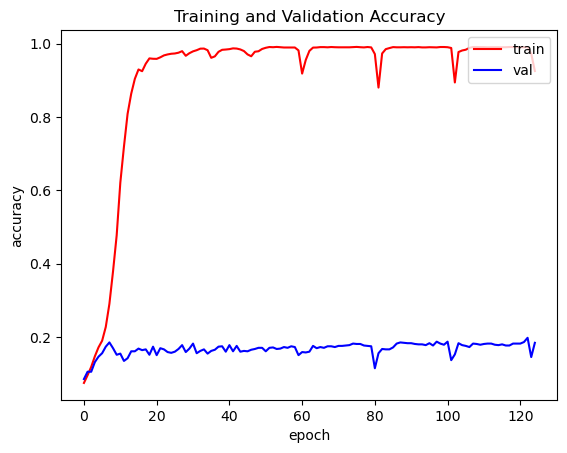

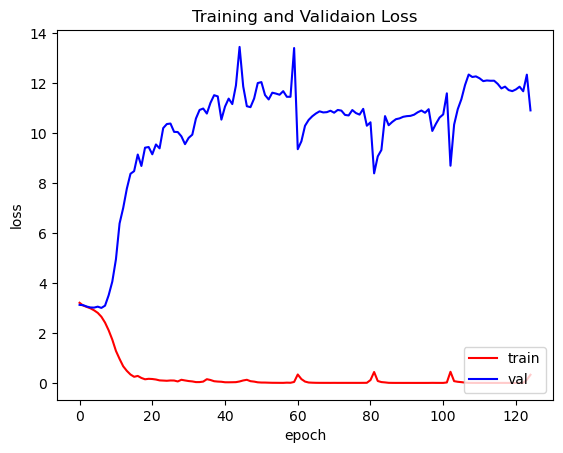

<Figure size 640x480 with 0 Axes>

In [41]:
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.title('Training and Validaion Loss')
plt.figure()

In [43]:
model.save('./models/cnn-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras')